# Assignment2 - Supervised Learning flow

## Part 1 - Student details:

In [3]:
# student 1: Yam 3004
# student 2:

## Part 2 - Initial Preparations

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [9]:
df_train = pd.read_csv("titanic_train.csv")
df_test  = pd.read_csv("titanic_test.csv")

In [10]:
df_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [11]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


### Data Cleansing

#### 1. Detecting duplications

In [14]:
all_duplicated_rows = df_train.duplicated(keep=False)
all_duplicated_entries = df_train[all_duplicated_rows]

keep_first_duplicated_rows = df_train.duplicated(keep='first')
keep_first_duplicated_entries = df_train[keep_first_duplicated_rows]

num_of_rows_with_duplications = len(all_duplicated_entries) - len(keep_first_duplicated_entries)

print(f"Train dataset has {num_of_rows_with_duplications} rows that have one or more duplications ({len(keep_first_duplicated_entries)} duplications in total).")

all_duplicated_entries = all_duplicated_entries.sort_values(by=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived'], ascending=True)
print(f"\nThe dataset below displays these rows and their duplications ({len(all_duplicated_entries)} rows).\n")
print(all_duplicated_entries)

Train dataset has 45 rows that have one or more duplications (80 duplications in total).

The dataset below displays these rows and their duplications (125 rows).

     Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
256       1    0  24.000000      0      0  69.3000         1         1
554       1    0  24.000000      0      0  69.3000         1         1
203       1    1  29.699118      0      0  27.7208         1         0
435       1    1  29.699118      0      0  27.7208         1         0
242       1    1  62.000000      0      0  26.5500         0         0
..      ...  ...        ...    ...    ...      ...       ...       ...
607       3    1  29.699118      8      2  69.5500         0         0
84        3    1  34.000000      0      0   8.0500         0         0
459       3    1  34.000000      0      0   8.0500         0         0
67        3    1  44.000000      0      0   8.0500         0         0
269       3    1  44.000000      0      0   8.0500     

The train dataset has 45 feature vectors that have one or more duplications (80 duplications in total). 
Since the train dataset doesn't include features with unique values, it is possible that duplicated feature vectors describe different passengers that have the same attributes, so just removing all these duplicates might eliminate meaningful information and affect a model. We will not perform the more complicated duplication analysis so we will retain all duplicated vectors in the train dataset.

#### 2. Detecting missing data

In [17]:
missing_values = df_train.isnull().sum()
print(missing_values)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


The train dataset has no missing data.

### EDA

#### 1. Overall Survival Percentage
We can see low overall survival percentage.

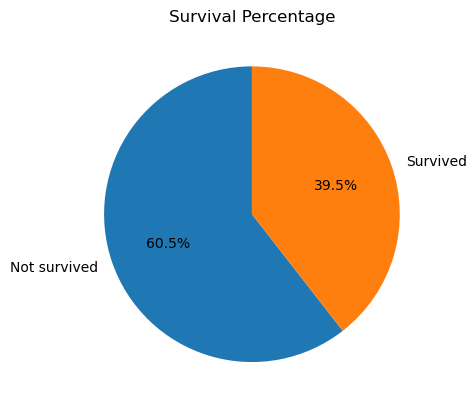

In [21]:
survival_counts = df_train['Survived'].value_counts()
plt.pie(survival_counts, labels = ['Not survived', 'Survived'], autopct = '%1.1f%%', startangle = 90) 
plt.title('Survival Percentage')
plt.show()

#### 2. General discussion

There was a common law "women and children first", so we can expect that women survival percentage is significantly greater than that of men. And the age group has a great importance.

#### 3. Survival by age group

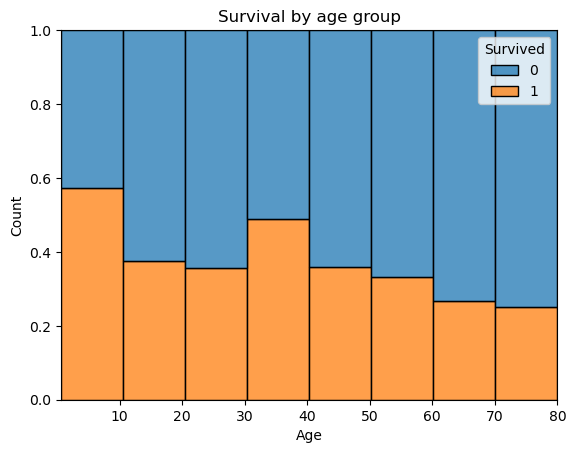

In [30]:
sns.histplot(data = df_train, x = 'Age', hue = 'Survived', bins = 8, multiple = 'fill', stat = 'count' )
plt.title('Survival by age group')
plt.show()

Visualizing this relation reveals the pattern that children and middle-aged passengers have a higher rate of survival, as well as older passengers has a lower one. This observation will be used lately for Feature Engineering. Instead of using age as a continuous variable, it can be transformed into age groups.

#### 4. Significance of passenger's sex feature

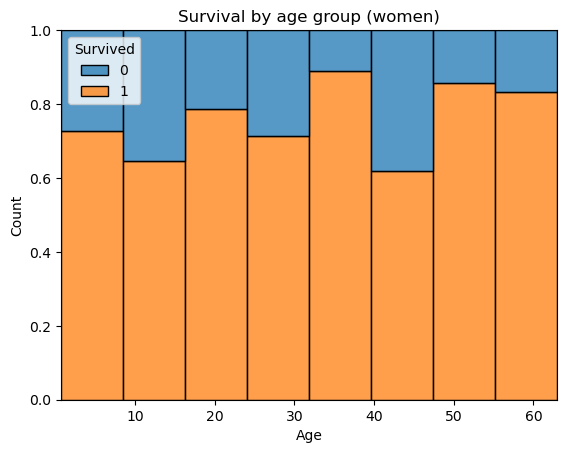

In [34]:
sns.histplot(data = df_train[df_train['Sex'] == 0], x = 'Age', hue = 'Survived', bins = 8, multiple = 'fill', stat = 'count' )
plt.title('Survival by age group (women)')
plt.show()

We can see that for women survival percentage is relatively close for all age groops, but for men survival percentage is significantly different. "Women and children first" law is clear.

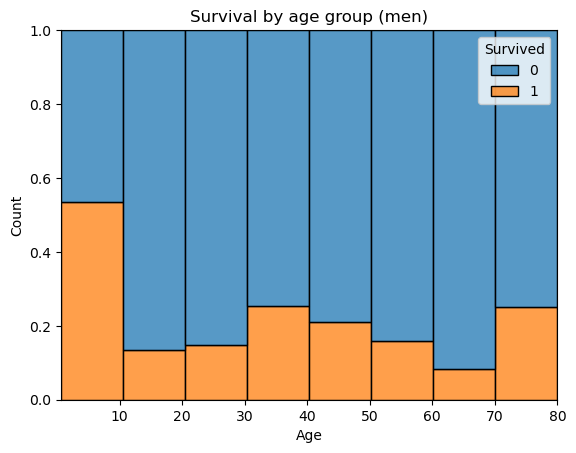

In [37]:
sns.histplot(data = df_train[df_train['Sex'] == 1], x = 'Age', hue = 'Survived', bins = 8, multiple = 'fill', stat = 'count' )
plt.title('Survival by age group (men)')
plt.show()

#### 5. Survival by passenger class

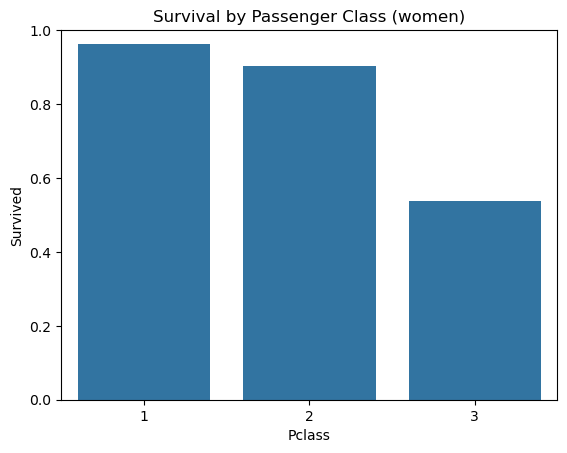

In [40]:
sns.barplot(data = df_train[df_train['Sex'] == 0], x='Pclass', y='Survived', ci=None)
plt.title('Survival by Passenger Class (women)')
plt.ylim(0,1)
plt.show()

We can see that passenger class is important feature, especially in the case of men.

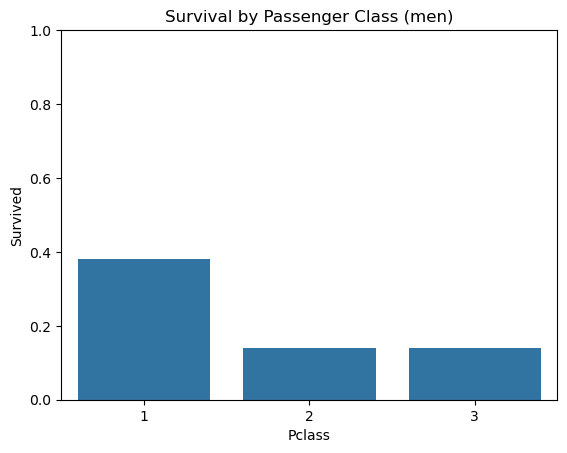

In [42]:
sns.barplot(data = df_train[df_train['Sex'] == 1], x='Pclass', y='Survived', ci=None)
plt.title('Survival by Passenger Class (men)')
plt.ylim(0,1)
plt.show()

### Feature Engineering

#### Creating a new feature

As mentioned above, we can create "Age Group" feature to interact more meaningfully with other features. This feature will be used in one of the data sets for model training and running cross validations.

In [47]:
# Create Age group 
bins = [0, 12, 18, 35, 60, 80]
labels = [0, 1, 2, 3, 4]
df_train['Age Group'] = pd.cut(df_train['Age'], bins=bins, labels=labels)
df_test['Age Group'] = pd.cut(df_test['Age'], bins=bins, labels=labels)

#### Feature selection using Recursive Feature Elimination
RFE eliminates the least important features. We are using the Random Forest model to determine feature importance.

In [51]:
# Use RandomForest for feature importance
model = RandomForestClassifier()

# Apply Recursive Feature Elimination (RFE)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = df_train[features]
y_train = df_train['Survived'];
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Show selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Fare'], dtype='object')


We will user this feature set for one of data sets for model training and running cross validations.

Note that 'Pclass', 'Sex', 'Age' features all are present in this reduced feature set, as we have supposed at EDA stage.

## Part 3 - Experiments

We will run cross validation for KNN and Decision Tree models.

Three feature sets are used: the full original feature set, the set with a new feature 'Age Group' replacing 'Age', and the set from the feature selection by RFE.

For KNN model Standard scaler is used besides non-scaled data.

Appropriate sets of several hyper parameters will be defined for each model.

In [56]:
# Lists for result's accumulation
used_features_list = []
best_estimator_list = []
best_params_list = []
f1_score_list = []
report_list = []

In [57]:
# The main function for grid search: 5-fold cross validation, macro-averaged f1 score
def grid_search_cv5_f1_macro_fit(classifier, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_predicted = best_estimator.predict(X_test)
    f1score = f1_score(y_test, y_predicted)
    report = classification_report(y_test, y_predicted, target_names=['Not Survived', 'Survived'], output_dict=True)
    
    # Save calculated results
    best_estimator_list.append(best_estimator)
    best_params_list.append(best_params)
    f1_score_list.append(f1score)
    report_list.append(report)

In [59]:
# Original train data set features
original_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Engineered train data set features with 'Age' being replaced by 'Age Group'
replaced_features = ['Pclass', 'Sex', 'Age Group', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Features selected by using by a backward search
reduced_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']

y_train = df_train['Survived']
y_test = df_test['Survived']

#### 6 grid searches for KNN model.

In [64]:
# KNN hyper parameters set
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

##### 1. The full features set without scaling.

In [67]:
X_train = df_train[original_features]
X_test = df_test[original_features]

In [69]:
grid_search_cv5_f1_macro_fit(KNeighborsClassifier(), knn_param_grid, X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((original_features, 0))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
F1 Score: 0.625
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.796875   0.686275  0.765363    0.741575      0.759184
recall         0.864407   0.573770  0.765363    0.719089      0.765363
f1-score       0.829268   0.625000  0.765363    0.727134      0.759657
support      118.000000  61.000000  0.765363  179.000000    179.000000


##### 2. The full feature set with standard scaling.

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
grid_search_cv5_f1_macro_fit(KNeighborsClassifier(), knn_param_grid, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((original_features, StandardScaler()))

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3}
F1 Score: 0.774
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.887931   0.761905  0.843575    0.824918      0.844984
recall         0.872881   0.786885  0.843575    0.829883      0.843575
f1-score       0.880342   0.774194  0.843575    0.827268      0.844168
support      118.000000  61.000000  0.843575  179.000000    179.000000


##### 3. The reduced feature set without scaling.

In [74]:
X_train = df_train[reduced_features]
X_test = df_test[reduced_features]

In [77]:
grid_search_cv5_f1_macro_fit(KNeighborsClassifier(), knn_param_grid, X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((reduced_features, 0))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9}
F1 Score: 0.619
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.795276   0.673077  0.759777    0.734176      0.753632
recall         0.855932   0.573770  0.759777    0.714851      0.759777
f1-score       0.824490   0.619469  0.759777    0.721979      0.754622
support      118.000000  61.000000  0.759777  179.000000    179.000000


##### 4. The reduced feature set with standard scaling.

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
grid_search_cv5_f1_macro_fit(KNeighborsClassifier(), knn_param_grid, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((reduced_features, StandardScaler()))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
F1 Score: 0.769
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.869919   0.803571  0.849162    0.836745      0.847309
recall         0.906780   0.737705  0.849162    0.822242      0.849162
f1-score       0.887967   0.769231  0.849162    0.828599      0.847504
support      118.000000  61.000000  0.849162  179.000000    179.000000


##### 5. The replaced feature set without scaling.

In [84]:
X_train = df_train[replaced_features]
X_test = df_test[replaced_features]

In [85]:
grid_search_cv5_f1_macro_fit(KNeighborsClassifier(), knn_param_grid, X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((replaced_features, 0))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
F1 Score: 0.637
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.803150   0.692308   0.77095    0.747729      0.765377
recall         0.864407   0.590164   0.77095    0.727285      0.770950
f1-score       0.832653   0.637168   0.77095    0.734911      0.766035
support      118.000000  61.000000   0.77095  179.000000    179.000000


##### 6. The replaced feature set with standard scaling.

In [87]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [88]:
grid_search_cv5_f1_macro_fit(KNeighborsClassifier(), knn_param_grid, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((replaced_features, StandardScaler()))

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5}
F1 Score: 0.758
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.879310   0.746032  0.832402    0.812671      0.833891
recall         0.864407   0.770492  0.832402    0.817449      0.832402
f1-score       0.871795   0.758065  0.832402    0.814930      0.833038
support      118.000000  61.000000  0.832402  179.000000    179.000000


#### 3 grid searches for Decision Tree model.

In [92]:
# Decision Tree hyper parameters set
dt_param_grid = {
    'max_depth': [3, 5, 7, 9],
    'max_leaf_nodes': [10, 20, 30, 40, 50]
}

##### 1. The full feature set without scaling.

In [100]:
X_train = df_train[original_features]
X_test = df_test[original_features]

In [102]:
grid_search_cv5_f1_macro_fit(DecisionTreeClassifier(), dt_param_grid, X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((original_features, 0))

Best parameters: {'max_depth': 9, 'max_leaf_nodes': 20}
F1 Score: 0.757
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.852713   0.840000  0.849162    0.846357      0.848381
recall         0.932203   0.688525  0.849162    0.810364      0.849162
f1-score       0.890688   0.756757  0.849162    0.823723      0.845047
support      118.000000  61.000000  0.849162  179.000000    179.000000


##### 2. The reduced feature set without scaling.

In [105]:
X_train = df_train[reduced_features]
X_test = df_test[reduced_features]

In [107]:
grid_search_cv5_f1_macro_fit(DecisionTreeClassifier(), dt_param_grid, X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((reduced_features, 0))

Best parameters: {'max_depth': 9, 'max_leaf_nodes': 20}
F1 Score: 0.748
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.842105   0.869565  0.849162    0.855835      0.851463
recall         0.949153   0.655738  0.849162    0.802445      0.849162
f1-score       0.892430   0.747664  0.849162    0.820047      0.843096
support      118.000000  61.000000  0.849162  179.000000    179.000000


##### 3. The replaced feature set without scaling.

In [110]:
X_train = df_train[replaced_features]
X_test = df_test[replaced_features]

In [112]:
grid_search_cv5_f1_macro_fit(DecisionTreeClassifier(), dt_param_grid, X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params_list[-1]}")
print(f"F1 Score: {f1_score_list[-1]:.3f}")
print(pd.DataFrame(report_list[-1]))
used_features_list.append((replaced_features, 0))

Best parameters: {'max_depth': 9, 'max_leaf_nodes': 20}
F1 Score: 0.768
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.859375   0.843137  0.854749    0.851256      0.853841
recall         0.932203   0.704918  0.854749    0.818561      0.854749
f1-score       0.894309   0.767857  0.854749    0.831083      0.851216
support      118.000000  61.000000  0.854749  179.000000    179.000000


#### Decide the best model from 9 greed seaches above.
We make decision based on best f1-score for positive event (a passenger is survived).
Note that this decision may have not the best accuracy.

In [115]:
# We take the first found best f1-score index.
best_f1_score = max(f1_score_list)
best_index = f1_score_list.index(best_f1_score)
best_estimator = best_estimator_list[best_index]
best_used_features = used_features_list[best_index][0]

print('The best F1 Score:')
print(f"{f1_score_list[best_index]:.3f}")
print('\nThe used features:')
print(best_used_features)
if used_features_list[best_index][1] == 0:
    print('\nScaler is not used\n')
else:
    display(used_features_list[best_index][1])

display(best_estimator_list[best_index])
print(pd.DataFrame(report_list[best_index]))

The best F1 Score:
0.774

The used features:
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


StandardScaler()

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.887931   0.761905  0.843575    0.824918      0.844984
recall         0.872881   0.786885  0.843575    0.829883      0.843575
f1-score       0.880342   0.774194  0.843575    0.827268      0.844168
support      118.000000  61.000000  0.843575  179.000000    179.000000


Note that the original full feature set is the best, and both choosen cases of feature engineering don't bring significant improvements.

## Part 4 - Training 
Using the best combination of feature engineering and model (algorithm and hyperparameters) from the experiment part (part 3)

In [119]:
X_train = df_train[best_used_features]
X_test = df_test[best_used_features]

if used_features_list[best_index][1] != 0:
    scaler = used_features_list[best_index][1]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

best_estimator.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

## Part 5 - Apply on test and show model performance estimation

In [122]:
y_predicted = best_estimator.predict(X_test)

f1score = f1_score(y_test, y_predicted)
report = classification_report(y_test, y_predicted, target_names=['Not Survived', 'Survived'], output_dict=True)

print(f1score)
print(pd.DataFrame(report))

0.7741935483870968
           Not Survived   Survived  accuracy   macro avg  weighted avg
precision      0.887931   0.761905  0.843575    0.824918      0.844984
recall         0.872881   0.786885  0.843575    0.829883      0.843575
f1-score       0.880342   0.774194  0.843575    0.827268      0.844168
support      118.000000  61.000000  0.843575  179.000000    179.000000


#### Print the confusion matrix

In [125]:
survival_counts = y_test.value_counts()
print(f'Not survived : {survival_counts[0]:3d}')
print(f'Survived     : {survival_counts[1]:3d}\n')

c_m = confusion_matrix(y_test, y_predicted)
print(f'True negative (Not survived): {c_m[0][0]:3d}')
print(f'False positive              : {c_m[0][1]:3d}')
print(f'True positive (Survived)    : {c_m[1][1]:3d}')
print(f'False negative              : {c_m[1][0]:3d}')

Not survived : 118
Survived     :  61

True negative (Not survived): 103
False positive              :  15
True positive (Survived)    :  48
False negative              :  13


#### Print the first 20 predictions

In [128]:
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_predicted,
    'Hit': (y_predicted == y_test)
})
comparison.head(20)

,Actual,Predicted,Hit
0,0,0,True
1,0,0,True
2,0,0,True
3,0,1,False
4,1,1,True
5,1,1,True
6,0,0,True
7,0,0,True
8,1,1,True
9,0,0,True
